# RDF Examples

## RDF of a Lennard-Jones Liquid

The RDF function in `asetools.analysis` performs similar to the one implemented in ASE itself but has some additional convenience features. For example, the `idx1` and `idx2` arguments accept any combination of atomic indices and elemental symbols and will automatically filter to avoid double counting. Also, there is a convenient switch to calculate the $g(z)$ for periodic surface model systems which is introduced below in more detail.

In the following, we will read in the trajectory file of a Argon Lennard-Jones liquid molecular dynamics simulation performed in ASE and use `asetools` to perform Radial Distribution Function analysis.

In [136]:
from ase.io.trajectory import Trajectory

traj = Trajectory("test_lj_liquid.traj")

The trajectory contains 100 images which are spaced 100 fs apart. Let's first visualize the last image from the simulation. During the simulation, atoms can travel beyond the periodic boundary conditions. This is internally compensated for by the PBC rules but looks a bit weird when we try to visualize the system. We can therefore use the `atoms.wrap` function to translate all atoms back into the confines of the simulation cell.

The `x3d` viewer is unfortunately quite rigid, so for the sake of proper display in this Jupyter notebook, we also need to translate the system's coordinates to be centered at the origin (where the fixed view camera is located) and then push it back into the $z$ direction to see the entire system.

In [137]:
from ase.visualize import view

# Read in the last image.
vis_atoms = traj[-1].copy()

# Wrap structure around the periodic boundaries.
vis_atoms.wrap()

# Translate for better viewing.
center = vis_atoms.cell.diagonal()
vis_atoms.set_positions(vis_atoms.get_positions() - center)
vis_atoms.translate([10, 15, -30])

view(vis_atoms, viewer="x3d")

We can now perform the analysis on the entire trajectory.

In [138]:
from asetools.analysis.rdf import rdf

g_r = rdf(traj, idx1="Ar", idx2="Ar")

Visualize the $g(z)$. The `g_r` return value from `asetools.analysis.rdf` is a list of lists of the form:

```python
g_r = [(r1, g(r1)), (r2, g(r2)), ..., (rN, g(rN))]
```

We can therefore use the reverse `zip` function to split `g_r` into two separate lists containg $r$ and $g(r)$ values, respectively.

Text(0, 0.5, '$g(r)$ / -')

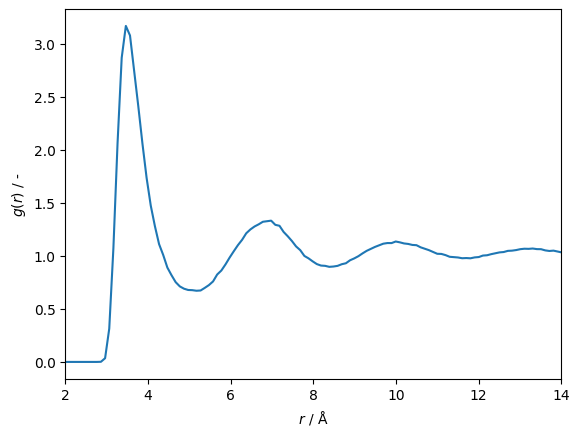

In [139]:
import matplotlib.pyplot as plt

x, y = zip(*g_r)

plt.plot(x, y)
plt.xlim([2,14])
plt.xlabel("$r$ / Å")
plt.ylabel("$g(r)$ / -")

## RDF of a Surface Model in Contact with Liquid

The `asetools` RDF function has a convenience feature built in to easily handle calculation of the $g(z)$ of surface models, *i.e.*, the $z$ distribution function. Here, we perform $g(z)$ analysis of a frozen Lennard-Jones surface in contact with a Lennard-Jones liquid.

First, read in and visualize the system as shown above.

In [140]:
# Read in the trajectory.
traj = Trajectory("test_lj_surface.traj")

# Read in the last image.
vis_atoms = traj[-1].copy()

# Wrap structure around the periodic boundaries.
vis_atoms.wrap()

# Translate for better viewing.
vis_atoms.rotate(-90, "x")
vis_atoms.translate([0, -20, -50])

view(vis_atoms, viewer="x3d")

We can now perform the $g(z)$ analysis. In this scenario, we enable the `surface = True` flag in `asetools.analysis.rdf` and supply the atomic index for one of the atoms in the top layer of the surface as `idx1`. The RDF function will then assume a $xy$ plane at the $z$ position of `idx1` to calculate all pair distances with. In this way, we can obtain the distribution of LJ liquid atoms as near the surface, where the surface itself is located at $r = 0$.

Finally, we also need to exclude the Ar atoms of the surface itself from the analysis. Conveniently, all surface atoms have `atoms.tag = 1` from this simulation. We can use this information to generate a list of atomic indices of just the LJ liquid atoms.

Text(0, 0.5, '$g(z)$ / -')

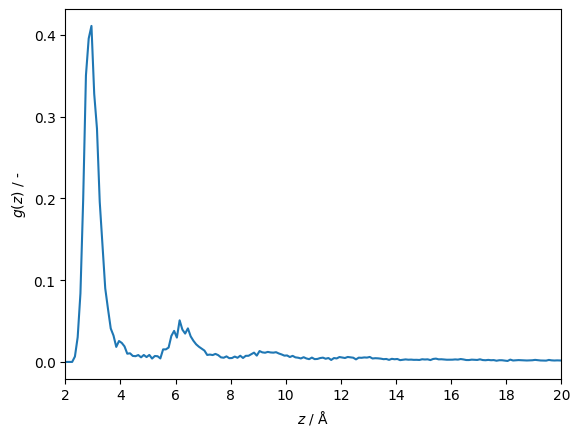

In [141]:
# Generate list of atomic indices of the liquid.
liquid_idx = [atom.index for atom in traj[0] if atom.tag != 1]

# Perform g(z) analysis.
g_z = rdf(traj, idx1=32, idx2=liquid_idx, surface=True)

# Visualize the results.
x, y = zip(*g_z)
plt.plot(x, y)
plt.xlim([2,20])
plt.xlabel("$z$ / Å")
plt.ylabel("$g(z)$ / -")